# Imports

In [1]:
import numpy as np
import sympy as sp
from sympy import *
import re

import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from math import log10, floor
from math import *
import math

from IPython.display import display, Latex
from IPython.display import Markdown as md

import scipy.constants as pc
from scipy.integrate import quad as quad
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats

# Matplotlib Parameters

In [2]:
rcParams['font.size'] = 16
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['axes.grid'] = True
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Latin Modern Math']
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams["xtick.minor.size"] =  4
rcParams["ytick.minor.size"] =  4
rcParams["xtick.minor.visible"] =  True
rcParams["ytick.minor.visible"] =  True
plt.rcParams["figure.autolayout"] = True

# Selfcoded functions

In [19]:
# Funktionen
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

# Formula for Gaussian error propagation with result
def DivisionMitFehler(A, deltaA, B, deltaB): # for C=A/B
    C = A/B
    deltaC = abs(C) * math.sqrt((deltaA / A)**2 + (deltaB / B)**2)
    return C,deltaC

def MultiplikationMitFehler(A, deltaA, B, deltaB): #for C=A*B
    C = A * B
    deltaC = abs(C) * ((deltaA / abs(A)) + (deltaB / abs(B)))
    return C, deltaC

# t-value for without literature value
def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)+(stu_2**2))))

# analytic linear regression y(x)=m*x + b calculates m
def bestM(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression y(x)=m*x + b calculates b
def bestB(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression calculates variance 
# (only used for next two functions, never gets called on its own, enhances readability) 
def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestB(x, y)+bestM(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

# analytic linear regression y(x)=m*x + b calculates error on m
def stuM(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

# analytic linear regression y(x)=m*x + b calculates error on b
def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

## Enter lab data

In [23]:
distanceA = 0.65
distanceAErr = 0.002

# First meassurement: Change in frequency
frequencies1 = np.array([20,30,40,50,60,70,80,90,100]) * 10**6
distancesB1 = np.array([2.3,2.7,4.0,4.65,5.0,5.65,6.2,7.65,8.7]) / 1000
distancesBErr = 0.2 / 1000

#Second meassurement: Change in Amplitudey
rfAmplitude2 = np.array([0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4,2.5,2.6])
outputPhotodiode2 = np.array([1.16,1.21,1.29,1.37,1.46,1.56,1.66,1.76,1.81,1.93,1.98,2.07,2.11,2.20,2.12,2.12,2.13,2.12,2.14
                              ,2.10,2.14,2.12])
distancesB2 = np.array([7.2,7.2,7.5,7.1,7.2,7.0,7.3,7.2,7.2,7.3,7.4,7.5,7.2,7.3,7.1,7.4,7.6,7.7,7.5,7.4,7.5,7.6])

#Measurement for speed of sound
beamWidth = 1.2/1000
beamWidthErr = 0.05 /1000

riseTime = 3.91e-6
riseTimeErr = 0.1e-6

## Plot lab data

In [33]:
#Varying Frequency

anglesFreq = np.arctan(distancesB1/distanceA) * 180/pi
anglesFreqErr = np.sqrt((distanceA/(distanceA**2 + distancesB1**2) * distanceAErr)**2 +
                       (distancesB1/(distanceA**2 + distancesB1**2) * distancesB1)**2)

for i in range(len(anglesFreq)):
    print(anglesFreq[i],anglesFreqErr[i])

0.20273806598452543 0.003076910026548613
0.2379964845364806 0.003076918364835252
0.35258496165650843 0.0030770395862169076
0.4098781998141587 0.0030771911744227405
0.44072807276101417 0.0030773098926562556
0.49802000241590816 0.0030776180744207815
0.5464970157613679 0.003077987878317971
0.6742961190132348 0.0030796127085397627
0.7668361817604762 0.0030815818773652975


In [34]:
# Varying Amplitude

anglesAmp = np.arctan(distancesB2/distanceA) * 180/pi
anglesAmpMean = np.mean(anglesAmp)
np.std(anglesAmp)

0.12480306613523554

### Part Two: Speed of sound measurement

In [22]:
betaConst = 0.66

speedSound1 = betaConst * beamWidth/riseTime
speedSound1Err = np.sqrt((0.66 / riseTime * beamWidthErr)**2 + (0.66 * beamWidth/riseTime**2 * riseTimeErr)**2)

print(speedSound1,r"\pm",speedSound1Err)

202.55754475703324 \pm 9.903002171913657


M: 144911658.94332284 +- 8581117.433771461
B: -6491508.7787492 +- 4217180.998174142
77.09300255784775


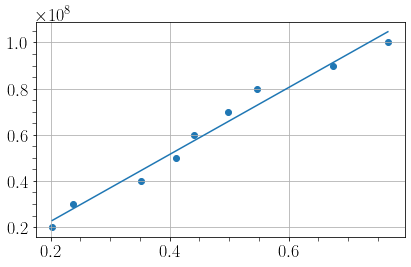

In [35]:
#Linear Regression fit

plt.scatter(anglesFreq, frequencies1)

#Linear Regression
speedSoundBestM = bestM(anglesFreq, frequencies1)
speedSoundBestB = bestB(anglesFreq, frequencies1)

speedSoundBestMErr = stuM(anglesFreq, frequencies1)
speedSoundBestBErr = stuB(anglesFreq, frequencies1)

plt.plot(anglesFreq, speedSoundBestM * anglesFreq + speedSoundBestB)

print("M:",speedSoundBestM,"+-",speedSoundBestMErr)
print("B:",speedSoundBestB,"+-",speedSoundBestBErr)

print(532e-9 * speedSoundBestM)

plt.savefig("speedSoundReg.pdf")